# Generative Models (160 + 40 points)

## Diffusion Models vs. GANs vs. VAE

### HW4 @ DL Course, Dr. Soleymani, Spring 2023

*Full Name:* Mehran Sarmadi

*SID:* 

In this notebook, we are going to implement Variational AutoEncoder (VAE), Denoising Diffusion Probabilistic Model (DDPM) and Generative Adversarial Network (GAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each model.

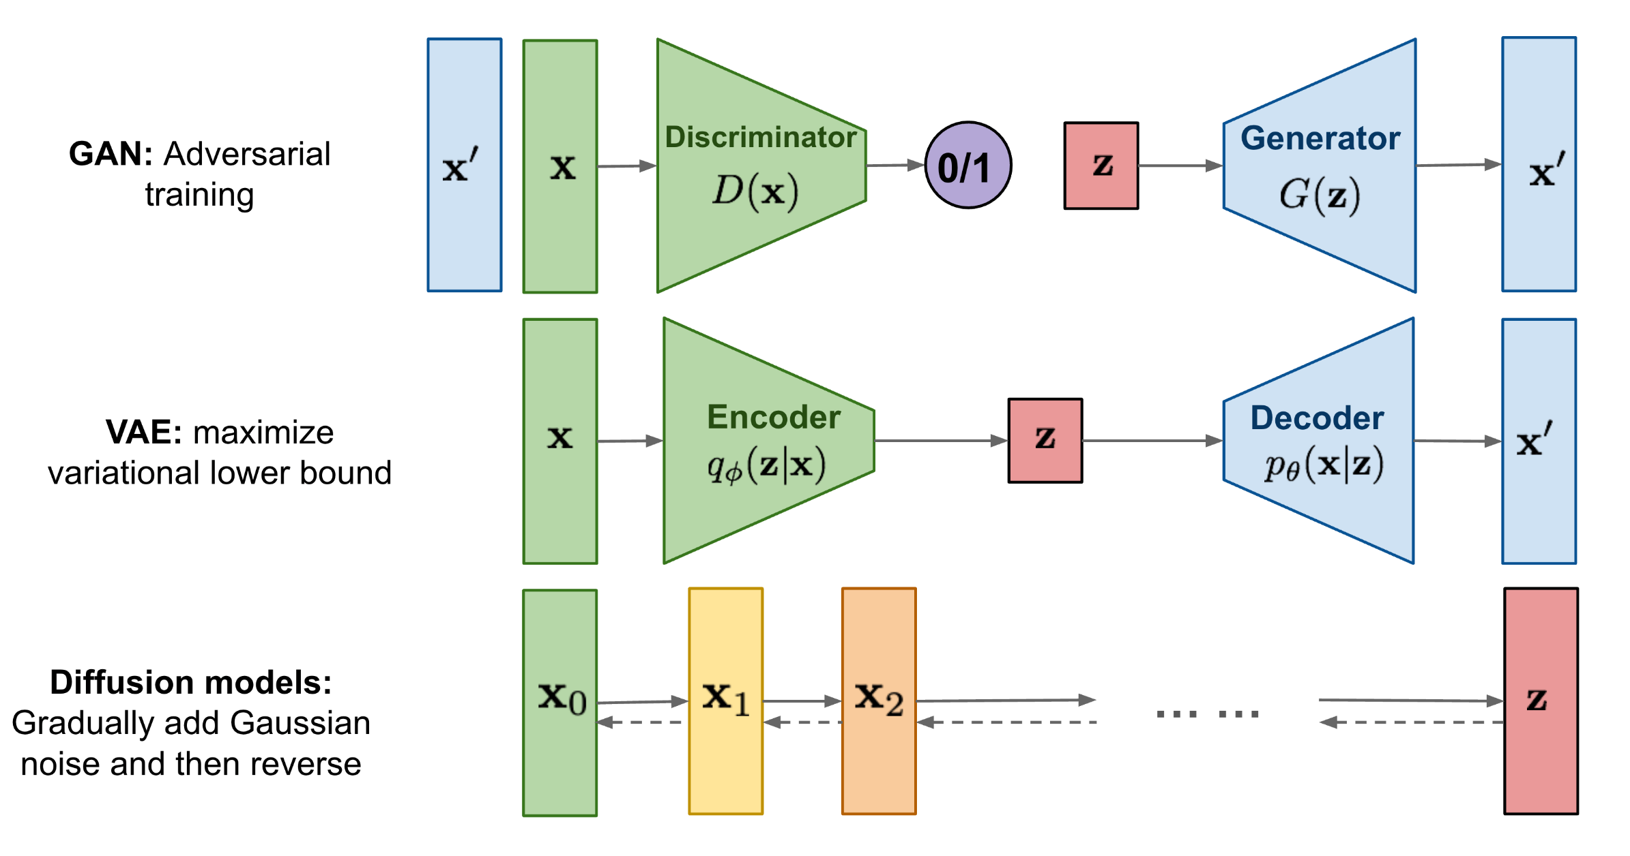

**NOTICE:** 
+ Please complete the code in the given structure. You may change the hyperparameters according to your computing power as long as the results indicate the desired performance.
+ Complete the `TODO` parts in the code accordingly. 
+ Remember to answer the conceptual questions. 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [1]:
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 8
IMG_SIZE = 64
C_IN = 1 # Number of input channels
LR = 3e-4
EPOCHS = 10

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

100%|██████████| 26421880/26421880 [00:01<00:00, 16152224.41it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 277668.48it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5082092.43it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23649810.51it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



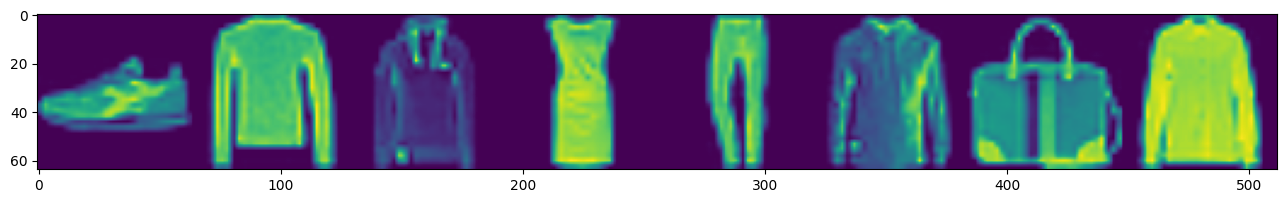

In [2]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## VAE (38 points)

VAE is a generative model consisting of an encoder network and a decoder network. The encoder maps the input data into a latent space, where the data is represented by probability distributions. A decoder network generates the output data from samples of the latent space.

VAE is trained using a variational inference approach, where the goal is to maximize the evidence lower bound (ELBO) of the log-likelihood of the data. The ELBO consists of two terms: the reconstruction loss, which measures how well the decoder can reconstruct the input data from the latent space, and the KL divergence between the prior (considered Gaussian) and posterior distributions over the latent space. The posterior distribution is usually considered Gaussian, and the encoder only tries to learn its mean and variance. Given the mean and the variance, one can use the reparameterization trick to sample from the encoder.

### ❓ **Question 1**
*(8 points)*

## Question 1 A

+ What is the reparameterization trick? How does it affect the sampling and the gradient backpropagation processes?


#**_My Answer :_**
<br>
Originally VAEs sample from a random node z
 which is approximated by the parametric model q(z∣ϕ,x)
 of the true posterior. Backprop cannot flow through a random node.

Introducing a new parameter ϵ
 allows us to reparameterize z
 in a way that allows backprop to flow through the deterministic nodes.
 <br>
 in this way :
 $$
 \tilde{z} = \mu_{\phi}(X)  + \epsilon\sigma_{\phi}(X)\:, \:\:where \:\: \epsilon\:\sim \:N(0,\:I)
 $$

## Question 1 B
+ What are the advantages of VAEs over regular Autoencoders?

#**_My Answer :_**
1.   VAEs are generative models that can generate new data samples by sampling from the learned latent space
2.   It's latent space has Continuity which means Similar point in the latent space will be similar after decoding
3.   It's latent space has Completeness which means Samples of the latent space leads to meaningful content after decoding

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super(VariationalEncoder, self).__init__()

        ##########################################################
        # TODO (4 points): 
        # Define your variational encoder layers. You may use 
        # linear layers, normalization layers, and activation layers. 
        ##########################################################
        self.img_2hid1 = nn.Linear(input_dim, h_dim//2)
        self.BatchNorm1 = nn.BatchNorm1d(h_dim//2)
        self.hid1_2hid2 = nn.Linear(h_dim//2, h_dim)
        self.BatchNorm2 = nn.BatchNorm1d(h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        self.relu = nn.ReLU()
        
        

    def forward(self, x):

        z = None
 
        ##########################################################
        # TODO (8 points): 
        # Convert `x` to the latent `z`. You should first calculate 
        # the mean and the variance for the current input `x` 
        # and then, sample a standard Gaussian noise. Finally convert 
        # the noise to `z` using the mean and the variance.
        ##########################################################
        h = self.relu(self.BatchNorm1(self.img_2hid1(x)))
        h = self.relu(self.BatchNorm2(self.hid1_2hid2(h)))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma*epsilon
        
        return z, mu, sigma

class Decoder(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super(Decoder, self).__init__()        
        
        ##########################################################
        # TODO (2 points): 
        # Define your decoder layers. You may use linear layers, 
        # normalization layers, and activation layers. 
        ##########################################################
        self.z_2hid1 = nn.Linear(z_dim, h_dim//2)
        self.hid1_2hid2 = nn.Linear(h_dim//2, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)
        self.relu = nn.ReLU()

    def forward(self, z):

        img = None

        ##########################################################
        # TODO (2 points): 
        # Decode the latent vector `z` to images.
        ##########################################################
        h = self.relu(self.z_2hid1(z))
        h = self.relu(self.hid1_2hid2(h))
        img = torch.sigmoid(self.hid_2img(h))
        
        return img

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super(VariationalAutoEncoder, self).__init__()

        ##########################################################
        # TODO (2 points): 
        # Instantiate the encoder and the decoder.
        ##########################################################

        self.encoder = VariationalEncoder(input_dim, h_dim, z_dim)
        self.decoder = Decoder(input_dim, h_dim, z_dim)

    def forward(self, x):
        z, mu, sigma = self.encoder(x)
        return self.decoder(z), mu, sigma

class VAEManager():
    def __init__(self, input_dim, h_dim=200, z_dim=20, l_rate=LR, epochs=EPOCHS):

        ##########################################################
        # TODO (1 points): 
        # Define the VAE and the optimizer. You can use Adam.
        ##########################################################
        self.epochs = epochs
        self.input_dim = input_dim**2
        self.vae = VariationalAutoEncoder(self.input_dim, h_dim, z_dim).to(DEVICE)
        self.optimizer = optim.Adam(self.vae.parameters(), lr=l_rate)
        self.loss_fn = nn.MSELoss(reduction='sum')


        

    def train(self, dataloader):

        history = dict(loss=[])
        for epoch in range(self.epochs):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.view(-1, self.input_dim).to(DEVICE)

                ##########################################################
                # TODO (8 points): 
                # Calculate the loss.
                # Then, perform the optimization on `batch_x`.
                ##########################################################
                
                # forward pass
                reconstructed_x, mu, sigma = self.vae(batch_x)

                #loss
                reconstruction_loss = self.loss_fn(reconstructed_x, batch_x)
                kl_div = - (0.5) * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

              

              
                loss = reconstruction_loss + kl_div
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)

            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, self.epochs, mean_loss)
            )

            self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history

    def sample(self, n, plot=True):

        ##########################################################
        # TODO (3 points): 
        # Interpolate between two randomly chosen points in the latent space,
        # and choose `n` equally-distant latent points between the random points.
        # You should save an array of random latent points in `zs`.
        ##########################################################
        
        random_z1 = torch.randn(1, 20).to(DEVICE)
        random_z2 = torch.randn(1, 20).to(DEVICE)
        alphas = torch.linspace(0, 1, n).unsqueeze(1).to(DEVICE)
        zs = random_z1 * alphas + random_z2 * (1 - alphas)

      

        with torch.no_grad():
            images = torch.cat([self.vae.decoder(z).view(1,1,64,64) for z in zs], dim=0).detach()
            if plot:
                plot_images(images)
            return images

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 1/10] [loss: 19923.4072]


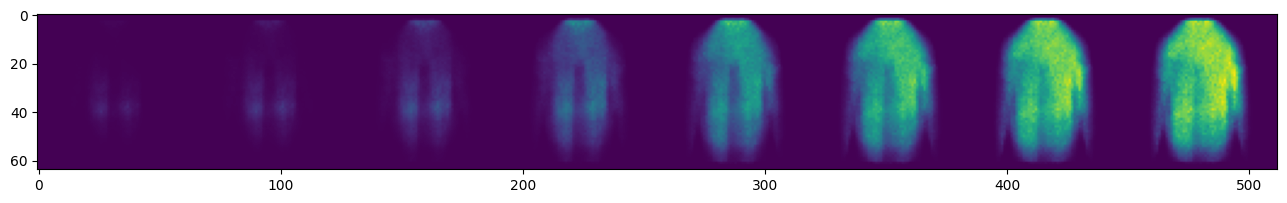

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 2/10] [loss: 19440.3099]


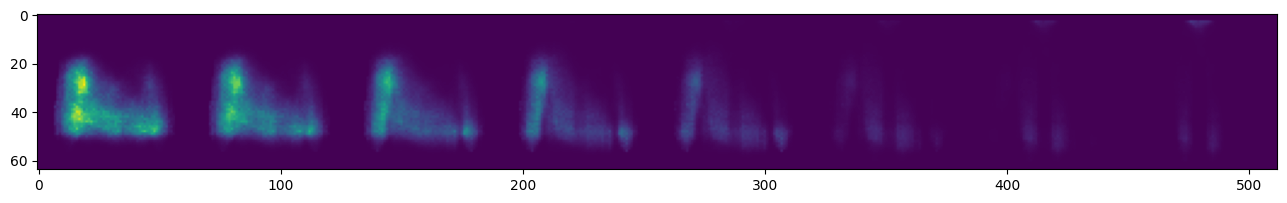

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 3/10] [loss: 19313.3142]


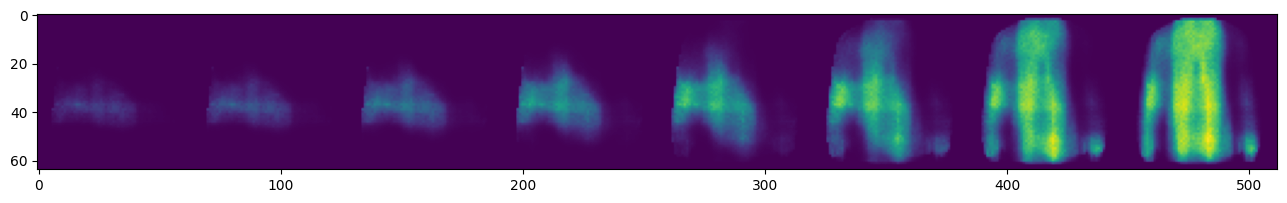

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 4/10] [loss: 19256.9774]


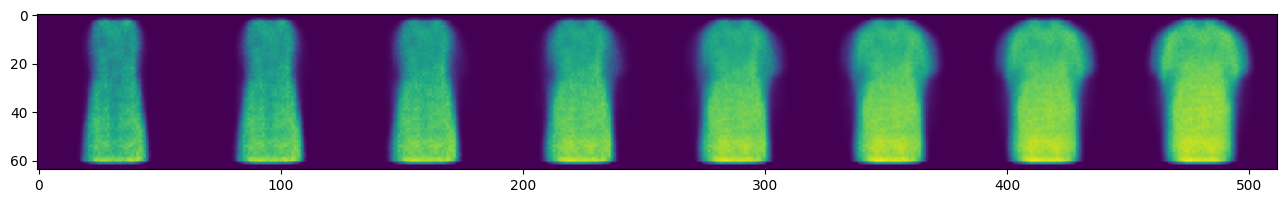

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 5/10] [loss: 19195.6609]


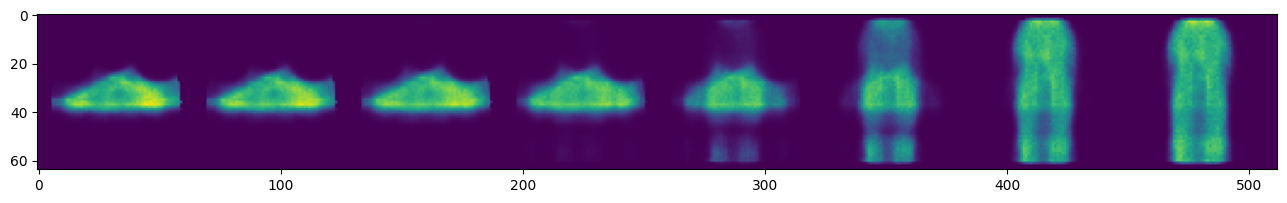

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 6/10] [loss: 19162.2612]


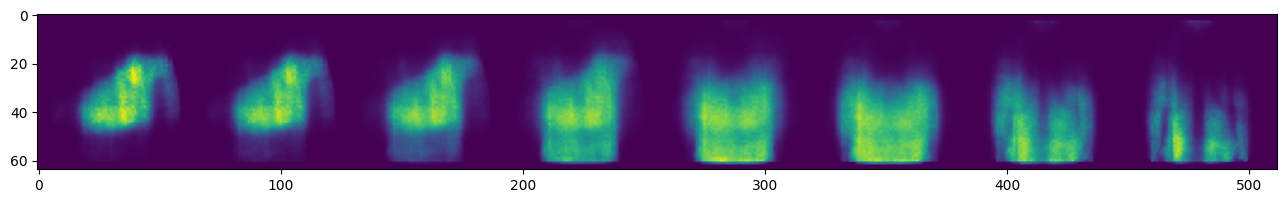

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 7/10] [loss: 19112.8550]


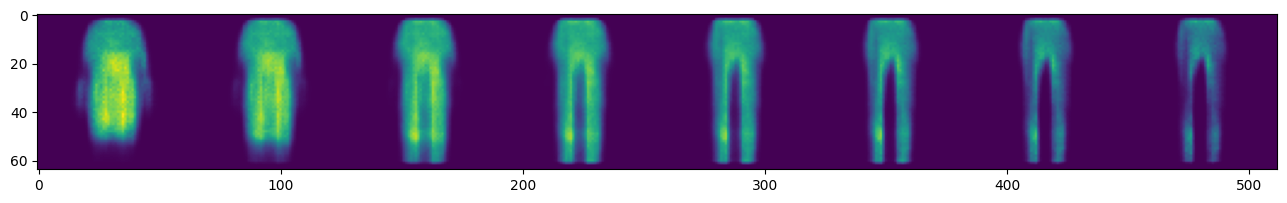

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 8/10] [loss: 19083.4892]


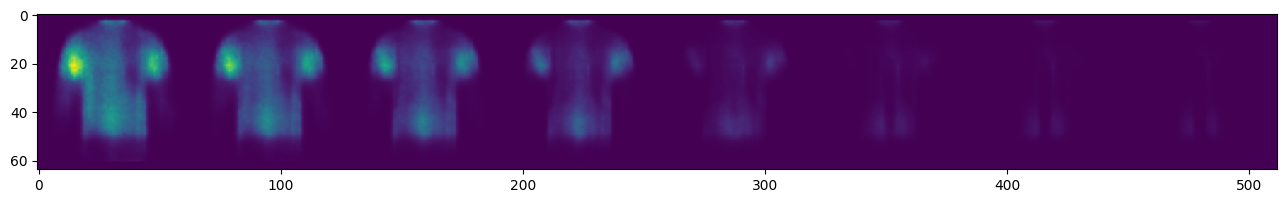

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 9/10] [loss: 19048.6707]


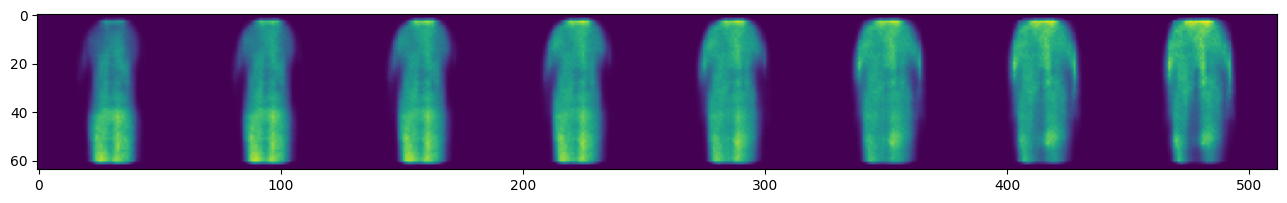

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 10/10] [loss: 19034.9863]


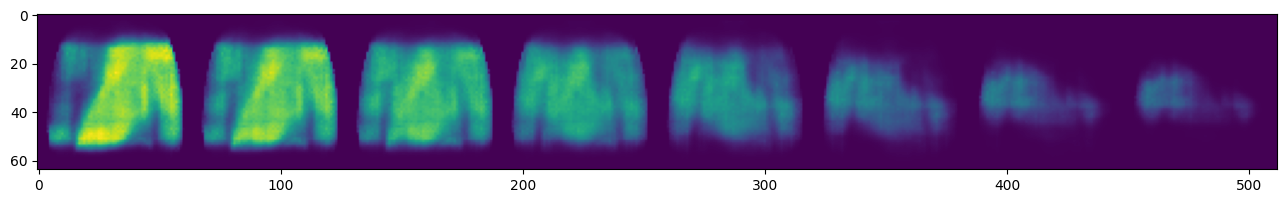

In [ ]:
vae = VAEManager(IMG_SIZE, epochs=EPOCHS) # You can pass your arguments to the call.
vae_history = vae.train(dataloader)

In [ ]:
print(vae_history)

{'loss': [19923.407249479165, 19440.309929427083, 19313.314157682293, 19256.977402213543, 19195.660925390624, 19162.261170182293, 19112.8549578125, 19083.48918658854, 19048.670718880207, 19034.98627122396]}


## GAN (39 + 15 points)

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

### ❓ **Question 2**
*(8 points)*
> What are the challenges in this optimization process? How do they address each of these challenges?

#**_My Answer :_**

Challenges :
1. training GANs requires finding Nash equilibria in high dimensional, continuous, non-convex games
2. GANs easily suffer from mode collapse 
3. Hyperparameter sensitivity

Solutions :
1.   Using other GAN variants like : Wassersterin GAN , g-GAN , ...
2.   applications of GANs are often limited to problems where it is acceptable for the model to produce a small number of distinct outputs
3.   Conducting a systematic hyperparameter search and tuning is necessary to find suitable settings.

In [ ]:
def intialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = 32
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()


        ##########################################################
        # TODO (2 points): 
        # Define the generator model here. You may use linear layers, 
        # normalization layers, and activation layers.  
        ##########################################################

        self.Gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 16, kernel_size=4, stride=1, padding=0, bias=False), #4*4
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            

            nn.ConvTranspose2d(features_g * 4, channels_img, kernel_size=4, stride=2, padding=1),
            
            nn.Tanh(),
        )

    def forward(self, z): 

        img = None

        ##########################################################
        # TODO (2 points): 
        # Generate images from the random noise `z`.
        ##########################################################
        img = self.Gen(z)

        return img

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        ##########################################################
        # TODO (2 points): 
        # Define the Discriminator model here. You may use linear 
        # layers, normalization layers, and activation layers.  
        ##########################################################
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
      
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 4, 1, kernel_size=4, stride=2, padding=0),

            nn.Sigmoid(),
            )
    
    def forward(self, img):

        real_or_fake = None

        ##########################################################
        # TODO (2 points): 
        # Predict whether each image in `img` is real or fake.
        ##########################################################
        
        real_or_fake = self.disc(img)


        return real_or_fake

class GANManager():
    def __init__(self, z_dim=100, channels_img=C_IN, features_g=32, features_d=32, epochs=EPOCHS, l_rate=LR):
        
        ##########################################################
        # TODO (3 points): 
        # 1) Instantiate the Generator and the Discriminator.
        # 2) Define your optimizer(s). You can use Adam.
        ##########################################################
        self.epochs = epochs
        self.z_dim = z_dim

        self.generator = Generator(z_dim, channels_img, features_g).to(DEVICE)
        self.discriminator = Discriminator(channels_img, features_d).to(DEVICE)

        intialize_weights(self.generator)
        intialize_weights(self.discriminator)

        self.opt_gen = optim.Adam(self.generator.parameters(), lr=l_rate, betas=(0.5, 0.999))
        self.opt_disc = optim.Adam(self.discriminator.parameters(), lr=l_rate,  betas=(0.5, 0.999))

        self.criterion = nn.BCELoss()

        


    def train(self, dataloader, **kwargs):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(self.epochs):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)

                ##########################################################
                # TODO (15 points): 
                # Calculate the loss for the Generator and the Discriminator.
                # Perform the optimization on `batch_x`.
                ##########################################################

                noise = torch.randn((BATCH_SIZE, self.z_dim, 1, 1)).to(DEVICE)
                fake = self.generator(noise)

                # training Discriminator

                disc_real = self.discriminator(batch_x).reshape(-1)
                loss_disc_real = self.criterion(disc_real, torch.ones_like(disc_real))
                disc_fake = self.discriminator(fake.detach()).reshape(-1)
                loss_disc_fake = self.criterion(disc_fake, torch.zeros_like(disc_fake))
                loss_disc = loss_disc_real + loss_disc_fake
                self.discriminator.zero_grad()
                loss_disc.backward()
                self.opt_disc.step()

                ### Training Generator
                output = self.discriminator(fake).reshape(-1)
                loss_gen = self.criterion(output, torch.ones_like(output))
                self.generator.zero_grad()
                loss_gen.backward()
                self.opt_gen.step()
                 


                
                total_g_loss.append(loss_gen.item())
                total_d_loss.append(loss_disc .item())


            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, self.epochs, mean_d_loss, mean_g_loss)
            )
            
            self.sample(8, plot=True)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):

        ##########################################################
        # TODO (1 points): 
        # First, assign proper Gaussian noises to `z`.
        # Then, use can see that by using the Generator, we can
        # make new images and plot them.
        ##########################################################

        z = torch.randn(8, self.z_dim, 1, 1).to(DEVICE)

        with torch.no_grad():
            gen_imgs = self.generator(z)
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 1/10] [D loss: 1.0122] [G loss: 1.3273]


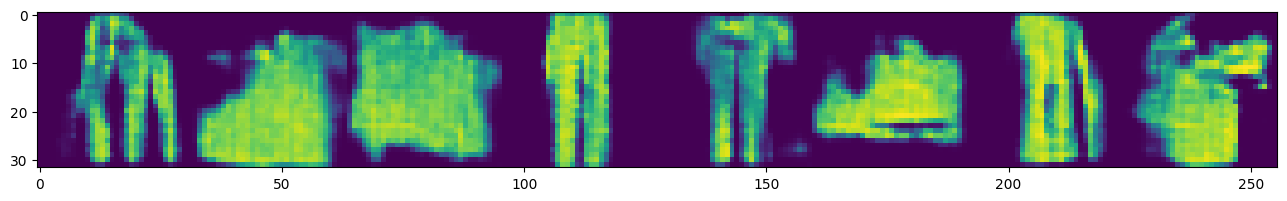

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 2/10] [D loss: 0.4480] [G loss: 2.7811]


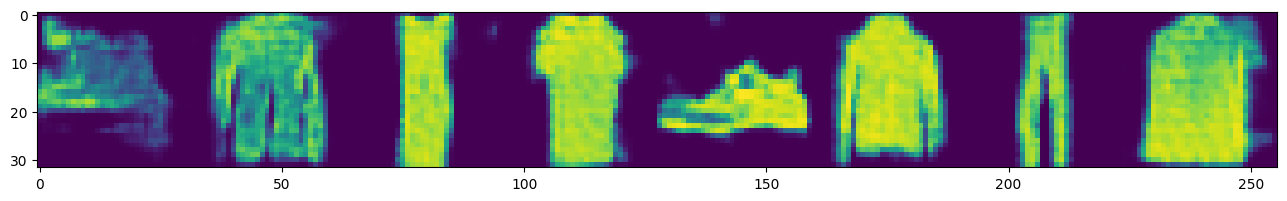

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 3/10] [D loss: 0.3157] [G loss: 3.5186]


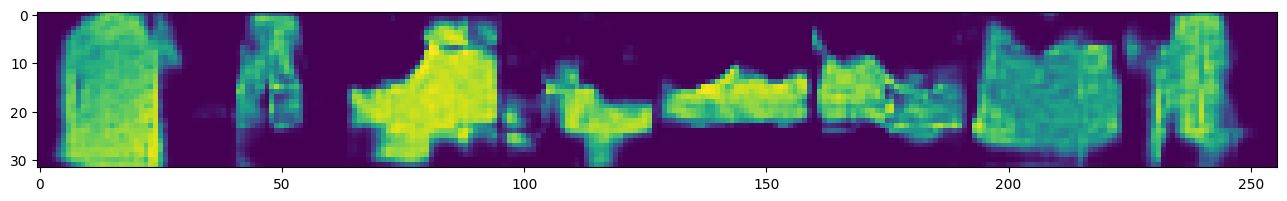

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 4/10] [D loss: 0.2762] [G loss: 3.9284]


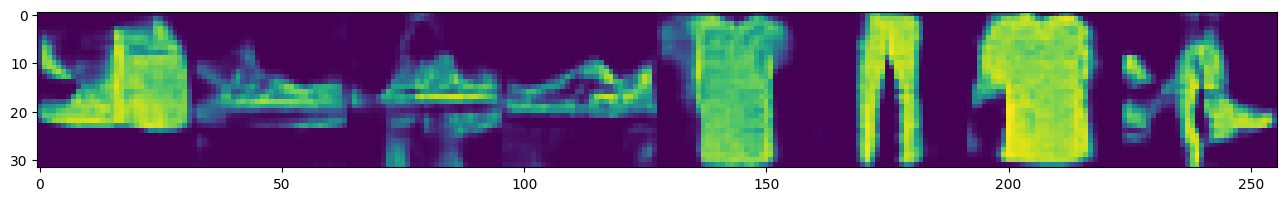

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 5/10] [D loss: 0.2563] [G loss: 4.1534]


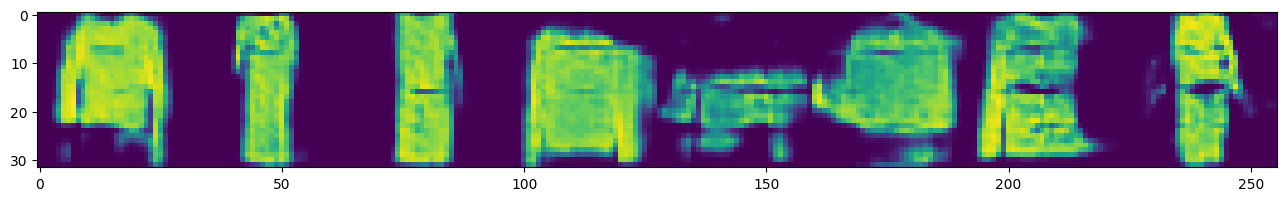

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 6/10] [D loss: 0.2408] [G loss: 4.2805]


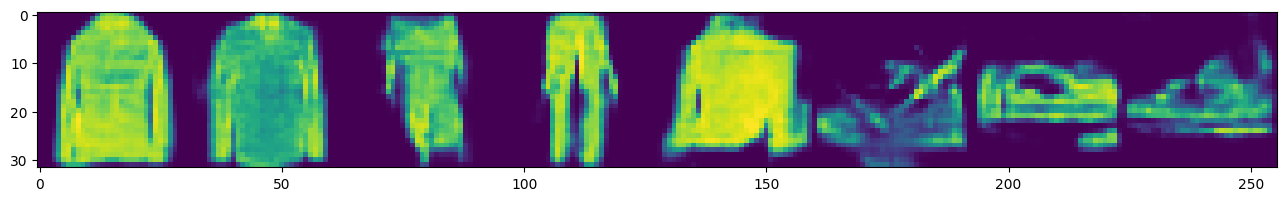

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 7/10] [D loss: 0.2114] [G loss: 4.5311]


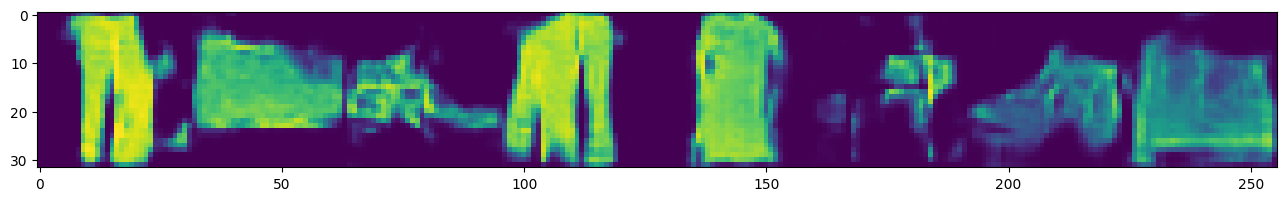

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 8/10] [D loss: 0.1946] [G loss: 4.7290]


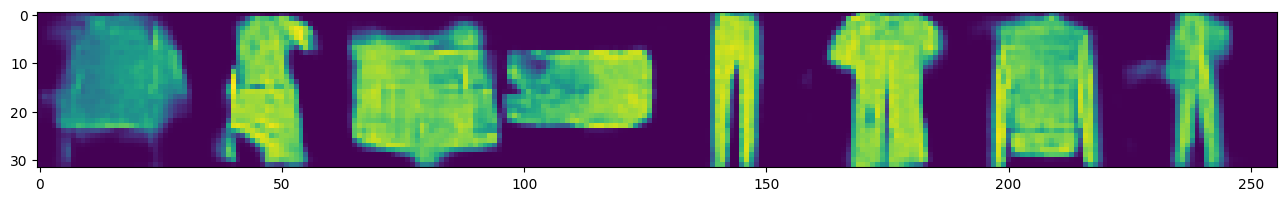

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 9/10] [D loss: 0.1828] [G loss: 4.8924]


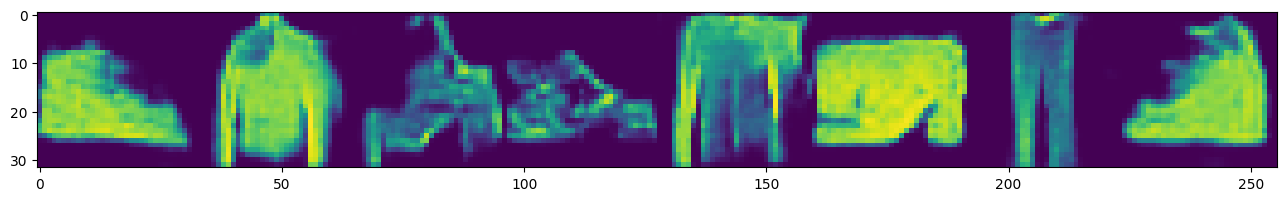

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 10/10] [D loss: 0.1547] [G loss: 5.1678]


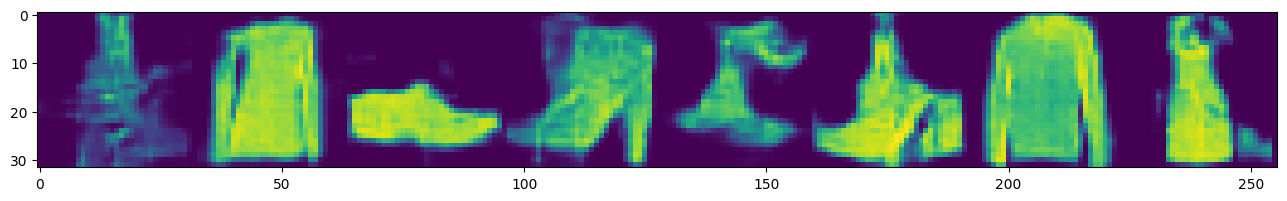

In [ ]:
gan = GANManager() # You can pass your arguments to the call.
gan_history = gan.train(dataloader)

In [ ]:
print(gan_history)

{'g_loss': [1.3272507411718368, 2.781109198129177, 3.5186478024403254, 3.9283699912468593, 4.15335440745689, 4.2804994587183, 4.531134485747417, 4.729023004349073, 4.8923965739091235, 5.167810176452001], 'd_loss': [1.0122195204893747, 0.44795604754090307, 0.3156523499387006, 0.2762270393890639, 0.25628201474503925, 0.24081926482201865, 0.2113784497885965, 0.19460669574951753, 0.18280323268743232, 0.15470787375676445]}


## ❓ **Question 3**
> - *(4 points)* How can we generate images from a specific class in GAN? 



#**_My Answer :_**
By using **conditional GAN** :

steps:

1.Modify the GAN architecture
>Extend the GAN architecture to incorporate conditional generation. This involves modifying both the generator and discriminator networks to take class labels as input.

2.Train the conditional GAN

3.Generate images from a specific class



- ## *(Bonus - 15 points)* 
Implement your idea and plot 8 images from each of the 10 classes.

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, num_classes=10, img_size=IMG_SIZE, embed_size=100):
        super(Generator, self).__init__()


        ##########################################################
        # TODO (2 points): 
        # Define the generator model here. You may use linear layers, 
        # normalization layers, and activation layers.  
        ##########################################################
        self.img_size = img_size
        self.Gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim + embed_size, features_g * 16, kernel_size=4, stride=1, padding=0, bias=False), #4*4
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            

            nn.ConvTranspose2d(features_g * 4, channels_img, kernel_size=4, stride=2, padding=1),
            
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, z, labels): 

        img = None

        ##########################################################
        # TODO (2 points): 
        # Generate images from the random noise `z`.
        ##########################################################
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([z, embedding], dim=1)
        img = self.Gen(x)

        return img

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes=10, img_size=IMG_SIZE):
        super(Discriminator, self).__init__()
        
        ##########################################################
        # TODO (2 points): 
        # Define the Discriminator model here. You may use linear 
        # layers, normalization layers, and activation layers.  
        ##########################################################
        self.img_size = img_size
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
      
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 4, 1, kernel_size=4, stride=2, padding=0),

            nn.Sigmoid(),
            )
        
        self.embed = nn.Embedding(num_classes, img_size*img_size)
    
    def forward(self, img, labels):

        real_or_fake = None

        ##########################################################
        # TODO (2 points): 
        # Predict whether each image in `img` is real or fake.
        ##########################################################
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([img, embedding], dim=1)
        real_or_fake = self.disc(x)


        return real_or_fake

class GANManager():
    def __init__(self, z_dim=100, channels_img=C_IN, features_g=32, features_d=32, epochs=EPOCHS, l_rate=LR):
        
        ##########################################################
        # TODO (3 points): 
        # 1) Instantiate the Generator and the Discriminator.
        # 2) Define your optimizer(s). You can use Adam.
        ##########################################################
        self.epochs = epochs
        self.z_dim = z_dim

        self.generator = Generator(z_dim, channels_img, features_g).to(DEVICE)
        self.discriminator = Discriminator(channels_img, features_d).to(DEVICE)

        intialize_weights(self.generator)
        intialize_weights(self.discriminator)

        self.opt_gen = optim.Adam(self.generator.parameters(), lr=l_rate, betas=(0.5, 0.999))
        self.opt_disc = optim.Adam(self.discriminator.parameters(), lr=l_rate,  betas=(0.5, 0.999))

        self.criterion = nn.BCELoss()

        


    def train(self, dataloader):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(self.epochs):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, labels) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)
                labels = labels.to(DEVICE)
                ##########################################################
                # TODO (15 points): 
                # Calculate the loss for the Generator and the Discriminator.
                # Perform the optimization on `batch_x`.
                ##########################################################

                noise = torch.randn((BATCH_SIZE, self.z_dim, 1, 1)).to(DEVICE)
                fake_labels = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)

                fake_images = self.generator(noise, fake_labels)
                


                # training Discriminator

                disc_real = self.discriminator(batch_x, labels).reshape(-1)
                loss_disc_real = self.criterion(disc_real, torch.ones_like(disc_real))
                disc_fake = self.discriminator(fake_images.detach(), fake_labels.detach()).reshape(-1)
                loss_disc_fake = self.criterion(disc_fake, torch.zeros_like(disc_fake))
                loss_disc = loss_disc_real + loss_disc_fake
                self.discriminator.zero_grad()
                loss_disc.backward()
                self.opt_disc.step()

                ### Training Generator
                output = self.discriminator(fake_images, fake_labels).reshape(-1)
                loss_gen = self.criterion(output, torch.ones_like(output))
                self.generator.zero_grad()
                loss_gen.backward()
                self.opt_gen.step()
                 


                
                total_g_loss.append(loss_gen.item())
                total_d_loss.append(loss_disc .item())


            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, self.epochs, mean_d_loss, mean_g_loss)
                 )
            
            self.sample(10, plot=True)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):

        ##########################################################
        # TODO (1 points): 
        # First, assign proper Gaussian noises to `z`.
        # Then, use can see that by using the Generator, we can
        # make new images and plot them.
        ##########################################################

        z = torch.randn(n, self.z_dim, 1, 1).to(DEVICE)
        labels = torch.arange(0, 10).to(DEVICE)
        

        with torch.no_grad():
            gen_imgs = self.generator(z, labels)
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 1/10] [D loss: 1.2580] [G loss: 0.9598]


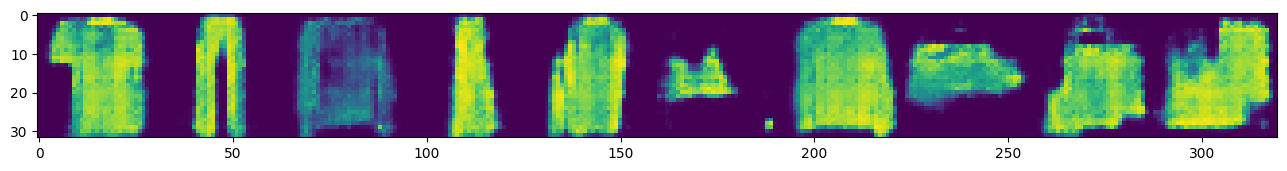

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 2/10] [D loss: 1.0742] [G loss: 1.3142]


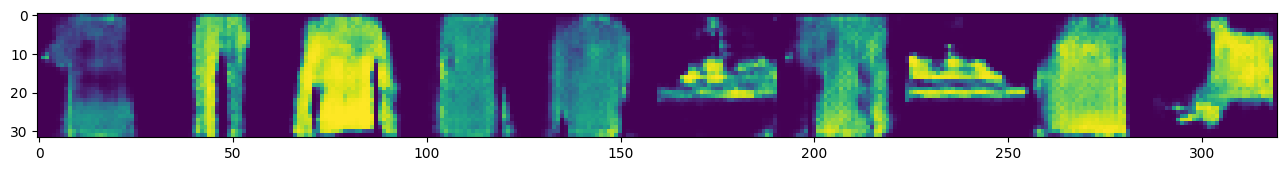

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 3/10] [D loss: 0.9567] [G loss: 1.5367]


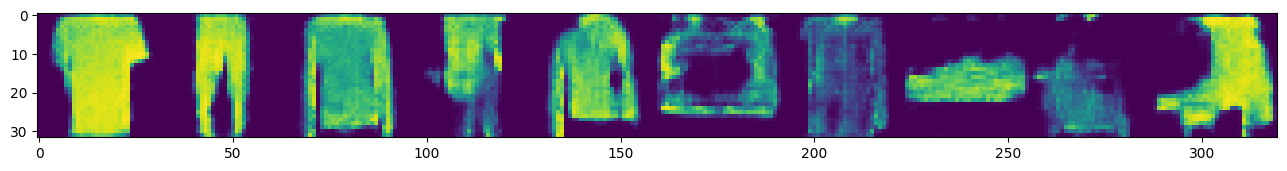

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 4/10] [D loss: 0.8843] [G loss: 1.6727]


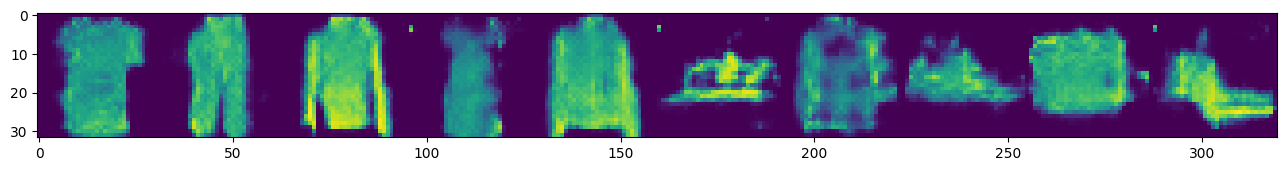

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 5/10] [D loss: 0.8330] [G loss: 1.8078]


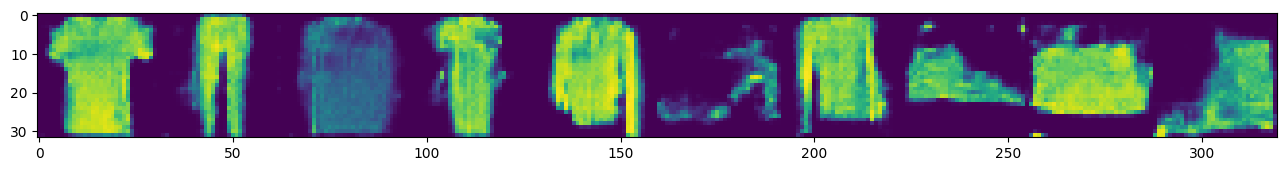

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 6/10] [D loss: 0.8002] [G loss: 1.8826]


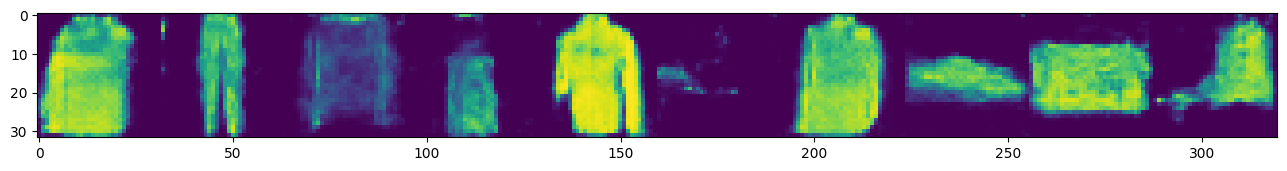

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 7/10] [D loss: 0.7470] [G loss: 1.9957]


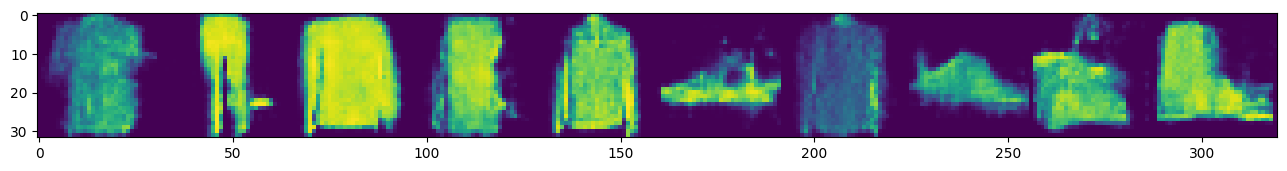

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 8/10] [D loss: 0.7140] [G loss: 2.0629]


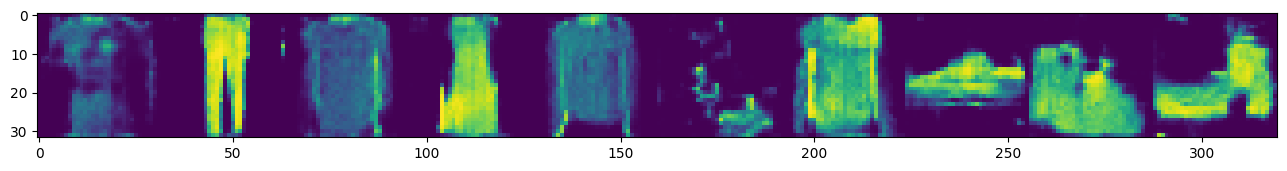

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 9/10] [D loss: 0.6661] [G loss: 2.2100]


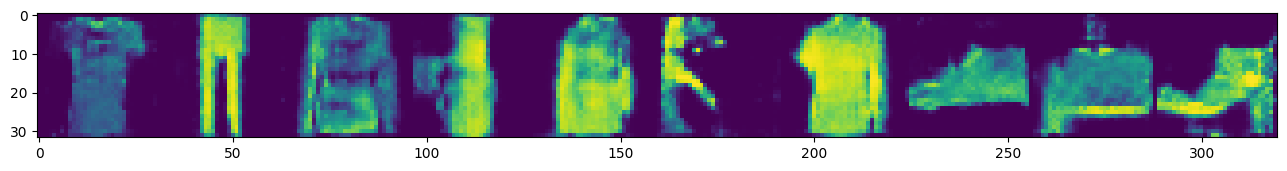

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 10/10] [D loss: 0.6259] [G loss: 2.3307]


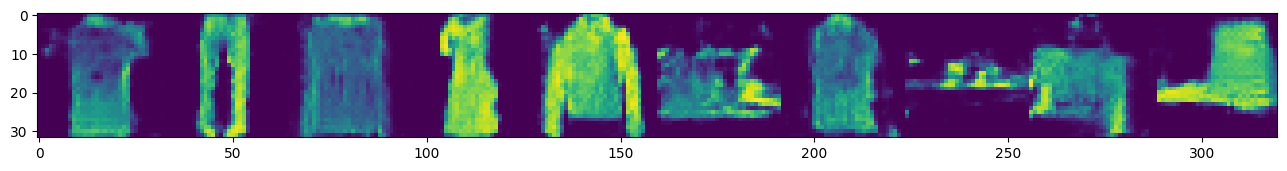

In [ ]:
gan = GANManager() # You can pass your arguments to the call.
Cgan_history = gan.train(dataloader)

## DDPM (73 + 25 points)

Denoising diffusion probabilistic models (DDPMs) learn to generate images by gradually denoising a completely random pattern in a step-by-step process. The model learns a set of diffusion steps that describe how the noise evolves through time and a denoising function that removes the noise at each time step. The denoising function is typically implemented as a neural network that takes in the noisy data and the time step as input and outputs the denoised data. After iterative denoising steps over a time index, an image from the training distribution is generated. The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.

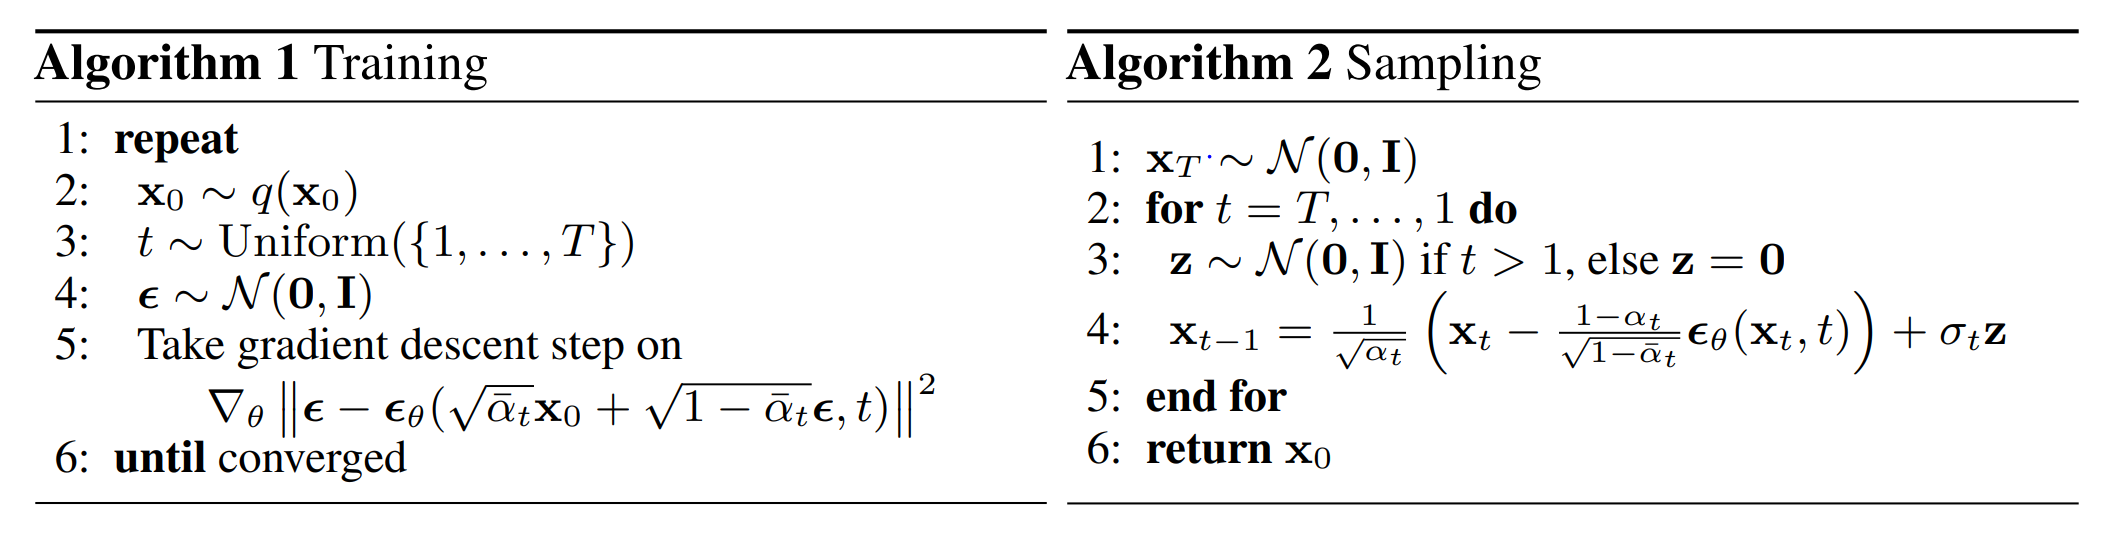

The pseudocode shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the architecture proposed by the paper, a UNet with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.
+ *Conditional UNet:* Each Up/Down block in UNet accepts positionally-encoded time as an input. The time index is encoded and added to the output of the block. You can use the sinusoidal position embeddings proposed in [Attention is All You Need.](https://arxiv.org/pdf/1706.03762.pdf)

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention 
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

In [3]:
BATCH_SIZE = 8
IMG_SIZE = 64
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)

In [4]:
##########################################################
# TODO (40 points): 
# Complete each class based on the previous explanations.
##########################################################

class ConvResNet(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvResNet, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels // 2, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels // 2),
            nn.GELU(),
            nn.Conv2d(mid_channels // 2, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )


    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvResNet(in_channels, in_channels, residual=True),
            ConvResNet(in_channels, out_channels),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            ConvResNet(in_channels, in_channels, residual=True),
            ConvResNet(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
            )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Attention(nn.Module):
    def __init__(self, channels, size):
        super(Attention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=DEVICE):
        super(UNet, self).__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = ConvResNet(c_in, 64)
        self.down1 = Down(64, 128)
        self.a1 = Attention(128, 32)
        self.down2 = Down(128, 256)
        self.a2 = Attention(256, 16)
        self.down3 = Down(256, 256)
        self.a3 = Attention(256, 8)

        self.bot1 = ConvResNet(256, 512)
        self.bot2 = ConvResNet(512, 512)
        self.bot3 = ConvResNet(512, 256)

        self.up1 = Up(512, 128)
        self.a4 = Attention(128, 16)
        self.up2 = Up(256, 64)
        self.a5 = Attention(64, 32)
        self.up3 = Up(128, 64)
        self.a6 = Attention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        #x2 = self.a1(x2)     #deactivated due to time limitation
        x3 = self.down2(x2, t)
        #x3 = self.a2(x3)     #deactivated due to time limitation
        x4 = self.down3(x3, t)
        x4 = self.a3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.a4(x)
        x = self.up2(x, x2, t)
        #x = self.a5(x)      #deactivated due to time limitation
        x = self.up3(x, x1, t)
        #x = self.a6(x)      #deactivated due to time limitation
        output = self.outc(x)
        return output


In [ ]:
model = UNet()

# Count the parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters: ", total_params)

Total trainable parameters:  12305057


In [ ]:
class DDPMManager():
    def __init__(self):

        self.T = 1000
        self.beta_start = 1e-4 # \beta_t is the sqrt(\sigma_t) from the pseudocode.
        self.beta_end = 0.02

        ##########################################################
        # TODO (6 points): 
        # Instantiate the model and the optimizer. You can use Adam.
        # Define \alpha, \beta, and \bar{alpha} for all T time steps. 
        # Use cosine scheduling for \beta.
        ##########################################################

        self.unet = UNet().to(DEVICE)
        self.optimizer = optim.AdamW(self.unet.parameters(), lr=3e-4)
        self.MSE = nn.MSELoss()

        self.beta = self.prepare_noise_schedule().to(DEVICE)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = IMG_SIZE
        self.device = DEVICE

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.T)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.T, size=(n,))

    

    def train(self, dataloader, **kwargs):

        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)

                ##########################################################
                # TODO (15 points): 
                # Sample a time step `t` and create noisy images for the  
                # `t`th step of the diffusion according to \bar{alpha} 
                # values. Then predict the noise using self.unet.
                # Compute the loss and backpropagate.
                ##########################################################

                t = self.sample_timesteps(batch_x.shape[0]).to(DEVICE)
                x_t, noise = self.noise_images(batch_x, t)
                predicted_noise = self.unet(x_t, t)
                loss = self.MSE(noise, predicted_noise)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()


          
                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )

            self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history
    
    def sample(self, n, plot=True):
        
        ##########################################################
        # TODO (8 points): 
        # Generate a random pattern `x`. 
        # Then denoise `x` for self.T time steps.
        # Choose `n` images from the generated images during self.T 
        # time steps (`xs`).
        # The purpose is to show how denoising converts the pure 
        # noise to an image after self.T time steps.
        ##########################################################
        xs = []
        with torch.no_grad():

            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.T)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = self.unet(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

               
                if i % (self.T//n) == 0 :
                  xs.append(x[0])
                elif i == 1 :
                  xs.append(x[0])

            images = torch.cat([x.view(1, 1, 64, 64) for x in xs], dim=0).detach()
  
            if plot:
              plot_images(images)


  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 1/10] [loss: 0.0248]


0it [00:00, ?it/s]

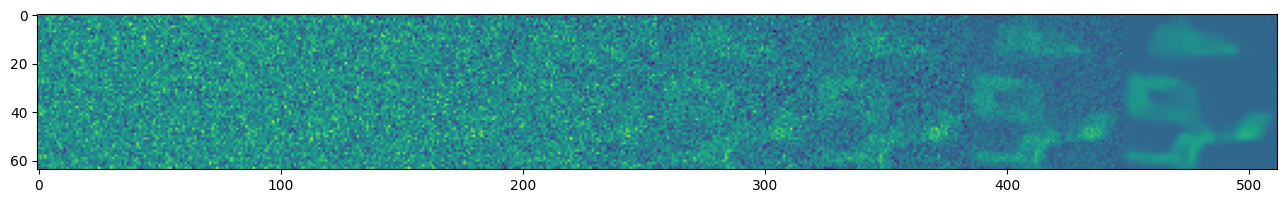

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 2/10] [loss: 0.0151]


0it [00:00, ?it/s]

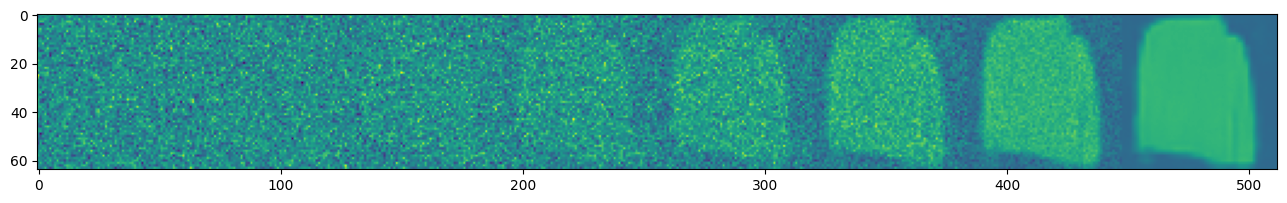

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 3/10] [loss: 0.0129]


0it [00:00, ?it/s]

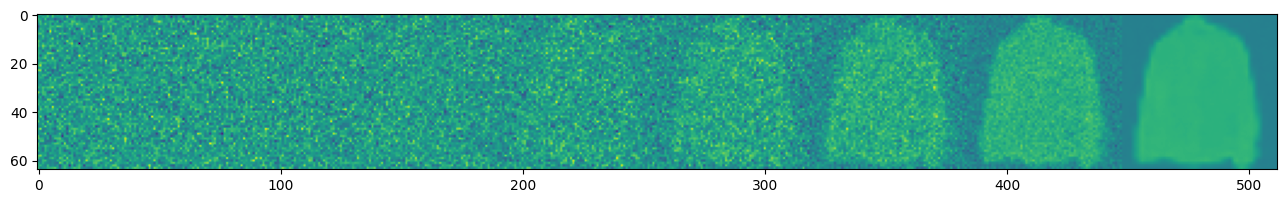

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 4/10] [loss: 0.0121]


0it [00:00, ?it/s]

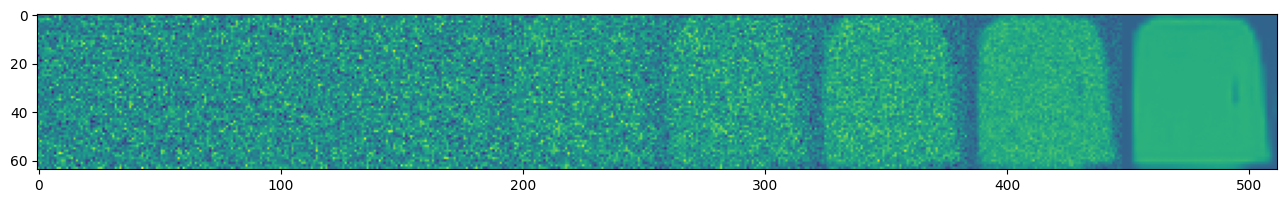

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 5/10] [loss: 0.0117]


0it [00:00, ?it/s]

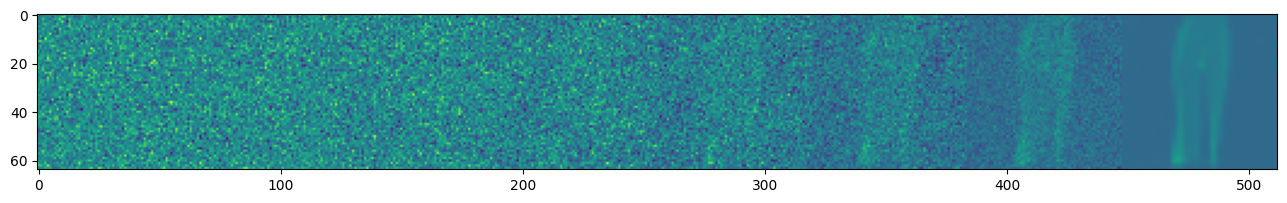

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 6/10] [loss: 0.0113]


0it [00:00, ?it/s]

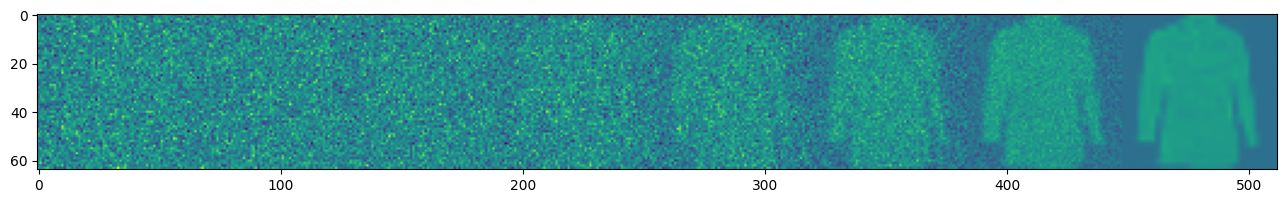

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 7/10] [loss: 0.0111]


0it [00:00, ?it/s]

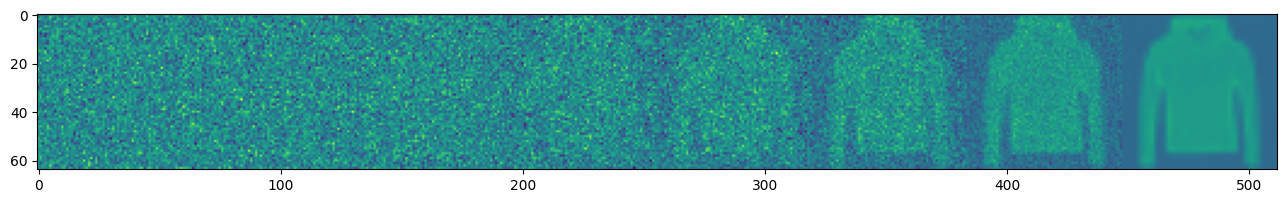

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 8/10] [loss: 0.0110]


0it [00:00, ?it/s]

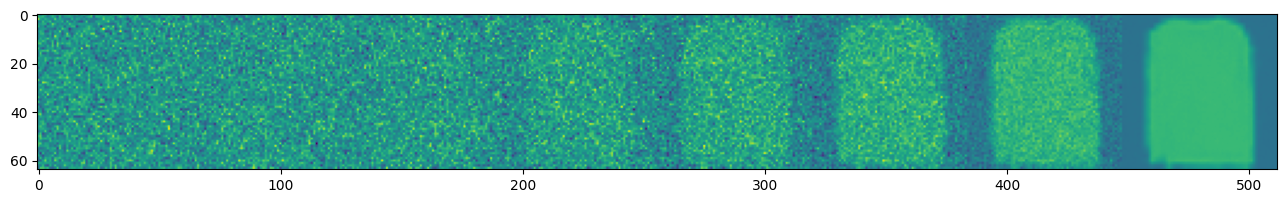

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 9/10] [loss: 0.0108]


0it [00:00, ?it/s]

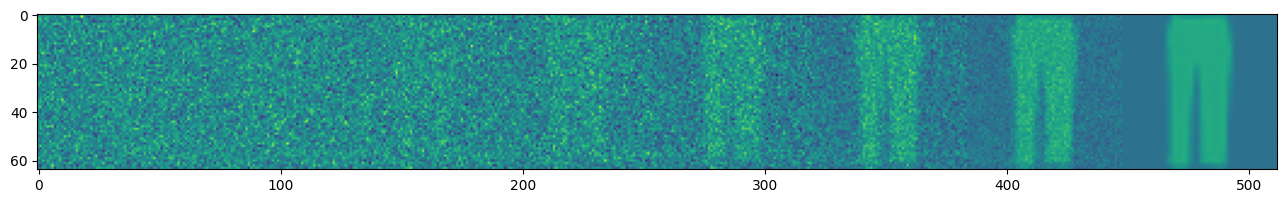

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 10/10] [loss: 0.0106]


0it [00:00, ?it/s]

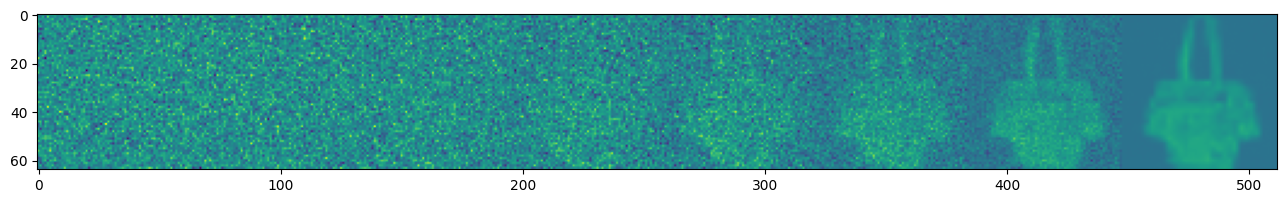

In [ ]:
ddpm = DDPMManager() # You can pass your arguments to the call.
ddpm_history = ddpm.train(dataloader)

In [ ]:
print(ddpm_history)

{'loss': [0.024815378248101722, 0.015069361060842251, 0.012870381463963227, 0.01210173545399836, 0.011723707698580499, 0.011318123096126752, 0.01105630871813434, 0.010959917832445354, 0.010793256631710877, 0.01062105139323976]}


### ❓ **Question 4**
> - *(4 points)* How can we generate images from a specific target class in DDPM?


# My Answer :
by using conditional DDPM 
these are conditional DDPM's steps:


1.Prepare the target class information
> This could be a one-hot vector representing the target class or any other form of class information that can be provided as input to the model.

2.Modify the conditioning mechanism
> the conditioning is typically done by adding Gaussian noise to the input data

3.Train the conditioned DDPM
> Train the DDPM model with the modified conditioning mechanism using a dataset containing samples from various classes, including the target class.   

4.Generate images from the target class





+ *(Bonus - 25 points)* Implement your idea and plot one trajectory of denoised images per class.

In [5]:
class UNet_conditional(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, num_classes=None, device=DEVICE):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = ConvResNet(c_in, 64)
        self.down1 = Down(64, 128)
        self.a1 = Attention(128, 32)
        self.down2 = Down(128, 256)
        self.a2 = Attention(256, 16)
        self.down3 = Down(256, 256)
        self.a3 = Attention(256, 8)

        self.bot1 = ConvResNet(256, 512)
        self.bot2 = ConvResNet(512, 512)
        self.bot3 = ConvResNet(512, 256)

        self.up1 = Up(512, 128)
        self.a4 = Attention(128, 16)
        self.up2 = Up(256, 64)
        self.a5 = Attention(64, 32)
        self.up3 = Up(128, 64)
        self.a6 = Attention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        #x2 = self.a1(x2)     #deactivated due to time limitation
        x3 = self.down2(x2, t)
        #x3 = self.a2(x3)     #deactivated due to time limitation
        x4 = self.down3(x3, t)
        x4 = self.a3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.a4(x)
        x = self.up2(x, x2, t)
        #x = self.a5(x)      #deactivated due to time limitation
        x = self.up3(x, x1, t)
        #x = self.a6(x)      #deactivated due to time limitation
        output = self.outc(x)
        return output

In [6]:
class DDPMManager_Conditional():
    def __init__(self):

        self.T = 1000
        self.beta_start = 1e-4 # \beta_t is the sqrt(\sigma_t) from the pseudocode.
        self.beta_end = 0.02

        ##########################################################
        # TODO (6 points): 
        # Instantiate the model and the optimizer. You can use Adam.
        # Define \alpha, \beta, and \bar{alpha} for all T time steps. 
        # Use cosine scheduling for \beta.
        ##########################################################

        self.unet_conditional = UNet_conditional(num_classes=10).to(DEVICE)
        self.optimizer = optim.AdamW(self.unet_conditional.parameters(), lr=3e-4)
        self.MSE = nn.MSELoss()

        self.beta = self.prepare_noise_schedule().to(DEVICE)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = IMG_SIZE
        self.device = DEVICE

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.T)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.T, size=(n,))

    

    def train(self, dataloader, **kwargs):

        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, labels) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)
                labels = labels.to(DEVICE)
                ##########################################################
                # TODO (15 points): 
                # Sample a time step `t` and create noisy images for the  
                # `t`th step of the diffusion according to \bar{alpha} 
                # values. Then predict the noise using self.unet.
                # Compute the loss and backpropagate.
                ##########################################################

                t = self.sample_timesteps(batch_x.shape[0]).to(DEVICE)
                x_t, noise = self.noise_images(batch_x, t)
                predicted_noise = self.unet_conditional(x_t, t, labels)
                loss = self.MSE(noise, predicted_noise)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )

            self.sample(10, plot=True)

            history['loss'].append(mean_loss)

        return history
    
    def sample(self, n, plot=True):
        
        ##########################################################
        # TODO (8 points): 
        # Generate a random pattern `x`. 
        # Then denoise `x` for self.T time steps.
        # Choose `n` images from the generated images during self.T 
        # time steps (`xs`).
        # The purpose is to show how denoising converts the pure 
        # noise to an image after self.T time steps.
        ##########################################################
      
        with torch.no_grad():

            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            labels = torch.arange(0, 10).to(self.device)
            for i in tqdm(reversed(range(1, self.T)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = self.unet_conditional(x, t, labels)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise


            images = torch.cat([img.view(1, 1, 64, 64) for img in x], dim=0).detach()
  
            if plot:
              plot_images(images)


  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 1/10] [loss: 0.0271]


0it [00:00, ?it/s]

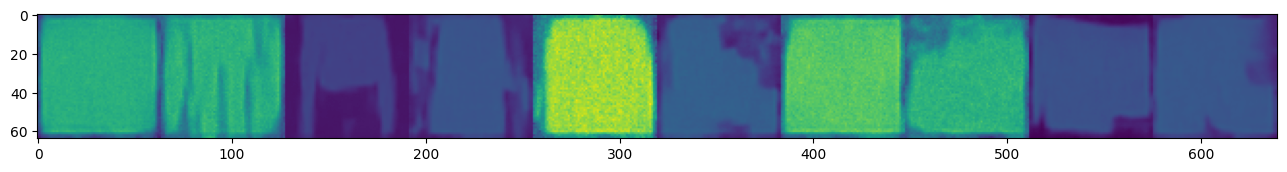

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 2/10] [loss: 0.0149]


0it [00:00, ?it/s]

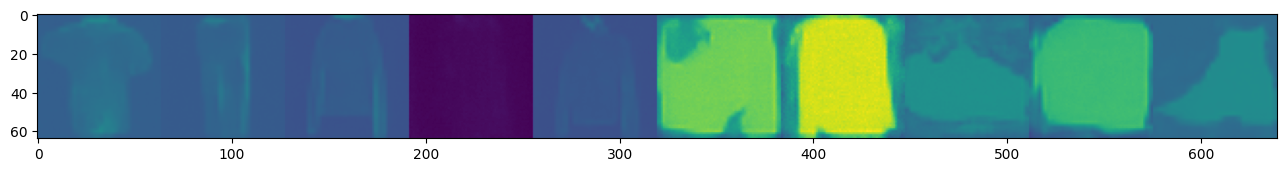

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 3/10] [loss: 0.0128]


0it [00:00, ?it/s]

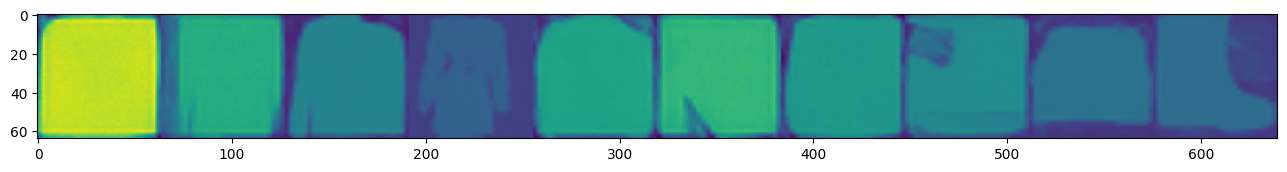

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 4/10] [loss: 0.0119]


0it [00:00, ?it/s]

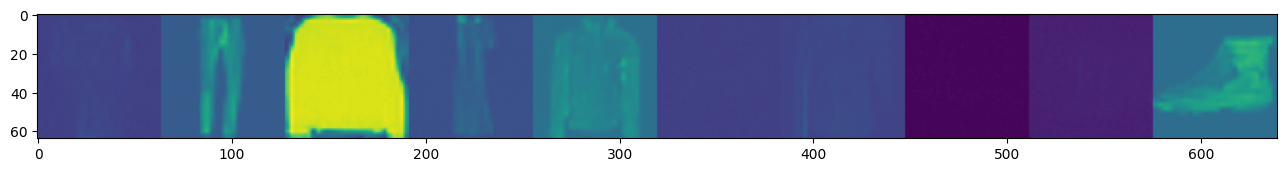

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 5/10] [loss: 0.0115]


0it [00:00, ?it/s]

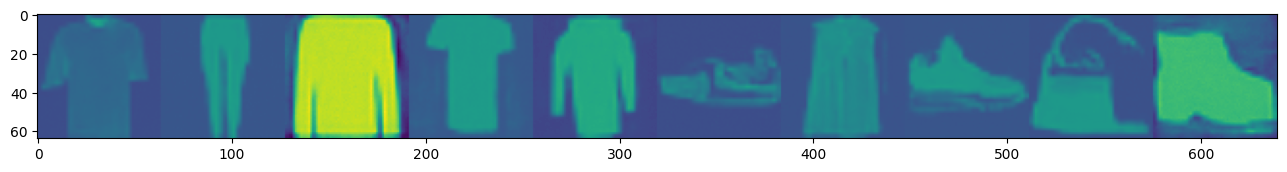

In [ ]:
ddpm = DDPMManager_Conditional() # You can pass your arguments to the call.
Cddpm_history = ddpm.train(dataloader)

## Comparisons (10 points)

History of each training has been stored in `[MODEL]_history`. Plot the losses for each model. Also sample images from each model and compare your results. 

In [12]:
# normalizing all model losses for comparing them
from sklearn import preprocessing
import numpy as np
vae = np.array(vae_history['loss'])
gan_g = np.array(gan_history['g_loss'])
gan_d = np.array(gan_history['d_loss'])
ddpm = np.array(ddpm_history['loss'])
vae_history_normalize = (vae - np.mean(vae))/np.std(vae)
gan_g_history_normalize = (gan_g - np.mean(gan_g))/np.std(gan_g)
gan_d_history_normalize = (gan_d - np.mean(gan_d))/np.std(gan_d)
ddpm_history_normalize = (ddpm - np.mean(ddpm))/np.std(ddpm)

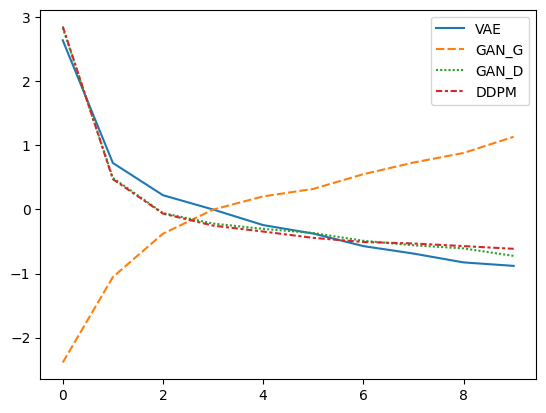

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'VAE': vae_history_normalize, 'GAN_G': gan_g_history_normalize, 'GAN_D': gan_d_history_normalize, 'DDPM': ddpm_history_normalize})

sns.lineplot(data=df)
plt.show()

**Almost all of them are decreasing the loss in the same way**